# Principal Component Analysis

Below are the Principal Component Analysis on the first 9 features:

1. index: Index for each data point
2. sim: Index for each simulation
3. mass: Total mass flow rate of air supply to the zone (kg/s)
4. tem_supply: Temperature of air supplied to the zone (°C)
5. tem_surf: Temperature of walls, ceiling, and floor (°C)
6. tem_win: Temperature of windows (°C)
7. n_occ: Number of occupants in zone
8. x: location of occupant of interest on x-axis (m)
9. y: location of occupant of interest on y-axis (m)

The last 3 features are treated as target predictions for evaluation purpose.

1. MRT:  Mean radiant temperature of the occupant of interest’s head and chest (°C)
2. T:    Average temperature of air surrounding the occupant of interest (°C)
3. V:    Average speed of air surrounding the occupant of interest occupant (°C)

In [1]:
data_loc = '../data/preprocessed/'

## Enclosed Office

### 1. Standardize the data

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

con_room_data = pd.read_csv(data_loc+"enclosed_office.csv")

# Remove the index column
con_room_data.drop(columns=['index', 'sim'], inplace=True)

# Seperate the data into features and labels
X = con_room_data.drop(columns=['MRT', 'T', 'V'])
y_MRT = con_room_data['MRT']
y_T = con_room_data['T']
y_V = con_room_data['V']

# Standardize the data
scaler = StandardScaler()
scaler.fit(X)

X_std = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_std.describe()


,mass,tem_supply,tem_surf,tem_win,n_occ,x,y
count,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02,720.000000,7.200000e+02,720.000000
mean,-1.102205e-15,-8.172475e-16,1.174986e-16,1.264421e-16,0.000000,-4.440892e-16,0.000000
std,1.000695e+00,1.000695e+00,1.000695e+00,1.000695e+00,1.000695,0.000000e+00,1.000695
min,-9.597991e-01,-1.248663e+00,-1.448365e+00,-1.303552e+00,-1.000000,-4.440892e-16,-1.000000
25%,-9.595023e-01,-9.487674e-01,-8.687326e-01,-9.304797e-01,-1.000000,-4.440892e-16,-1.000000
50%,-4.197757e-01,-4.979886e-02,1.375536e-04,9.659024e-02,0.000000,-4.440892e-16,0.000000
75%,1.379265e+00,8.484505e-01,8.691235e-01,1.029944e+00,1.000000,-4.440892e-16,1.000000
max,1.379898e+00,1.448242e+00,1.447946e+00,1.216779e+00,1.000000,-4.440892e-16,1.000000


### 2. Perform PCA

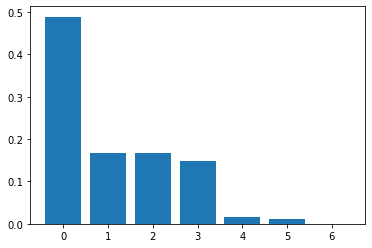

In [3]:
# Perform PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt

pca = PCA()
pca.fit(X_std)

e_vectors = pca.components_ # The eigenvectors
evr = pca.explained_variance_ratio_ # The variance explained by each eigenvector

# Save the eigenvectors to a text file
savetxt("../reports/data/pca_enclosed_office_eigenvectors_13f.csv", e_vectors, delimiter=',')

plt.bar(range(len(evr)), evr)
plt.savefig('../figures/evr_pca_enclosed_office_13f.png')

/tmp/ipykernel_101205/3863644822.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  X_pca.hist(bins=50, ax=ax)


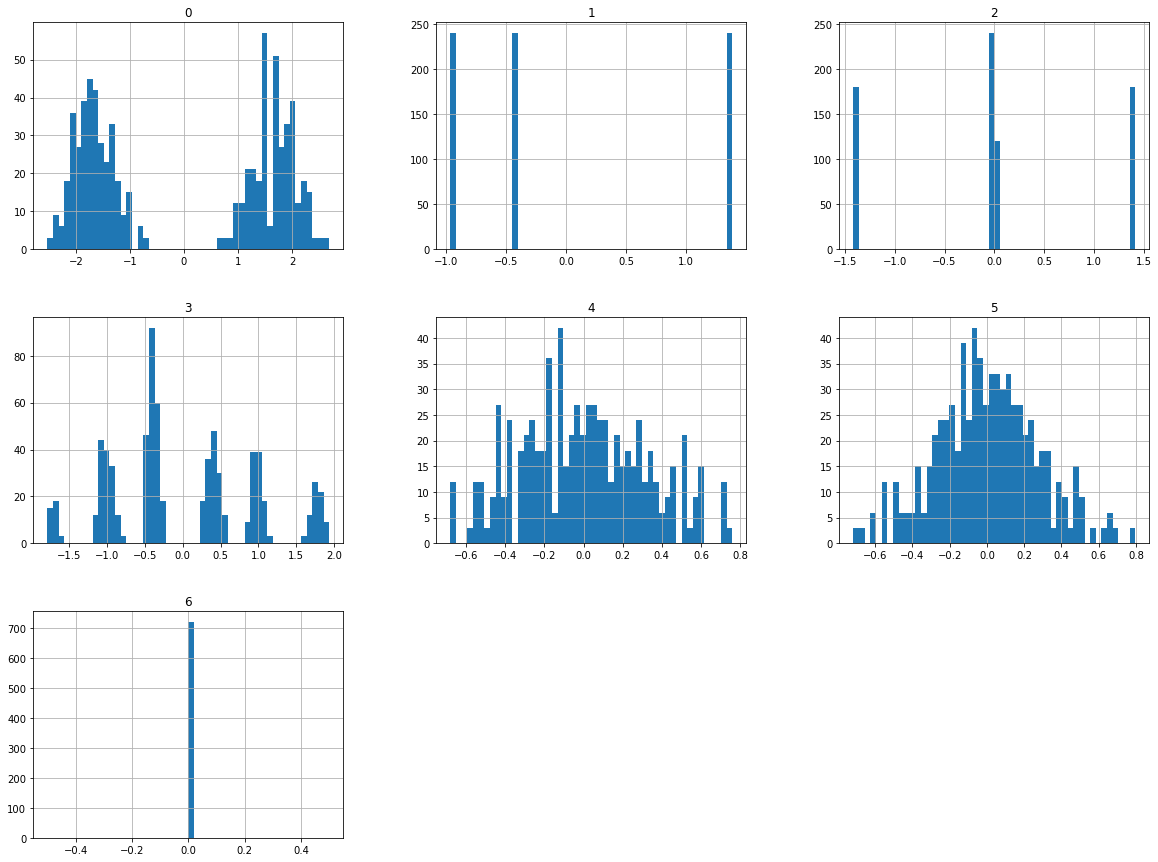

In [4]:
# Tramsform the data
X_pca = pd.DataFrame(pca.transform(X_std))
fig, ax = plt.subplots(figsize=(20,15))
X_pca.hist(bins=50, ax=ax)
fig.savefig('../figures/hist_pca_enclosed_office_13f.png')

### 3. Compare models' results with and without PCA on predicting MRT

#### 3.1 Split the data into training and testing

In [5]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split

# Without PCA
X_train, X_test, y_train, y_test = train_test_split(X_std, y_MRT, test_size=0.2, random_state=42)

# With PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_MRT, test_size=0.2, random_state=42)

#### 3.2 Train and evaluate the Linear Regression model

##### 3.2.1 Without PCA

Training time: 0.004685163497924805s
Mean squared error: 1.7880454889062574


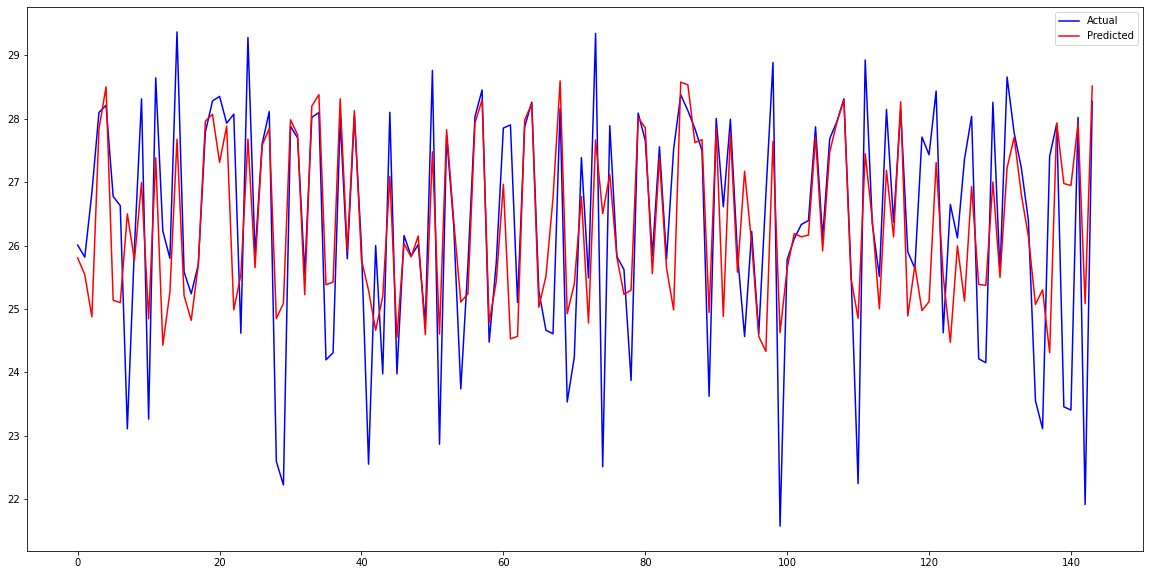

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
import time

# Train linear regression model on training data
model = LinearRegression()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
lr_train_time = stop - start
print(f"Training time: {lr_train_time}s")

# Save the model to a pickle file
filename = '../reports/models/lr_MRT_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred[:144], color='red', label='Predicted')
plt.legend()
plt.show()

##### 3.2.2 With PCA

Training time: 0.005322694778442383s
Mean squared error: 1.7880454889062571


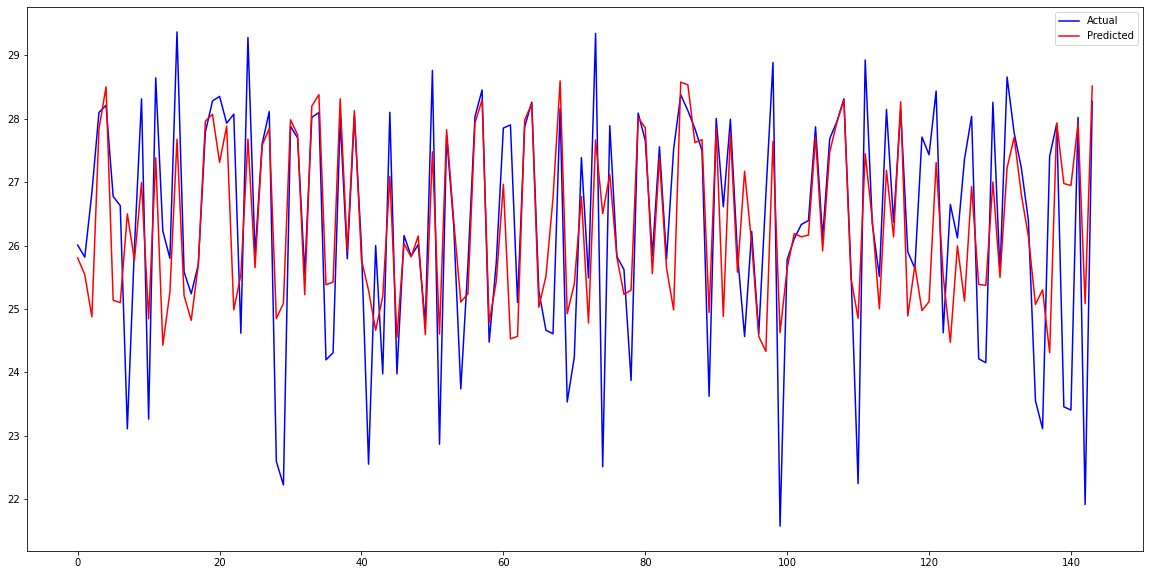

In [7]:
# Train linear regression model on training data
start = time.time()
model.fit(X_train_pca, y_train_pca)
stop = time.time()
lr_pca_train_time = stop - start
print(f"Training time: {lr_pca_train_time}s")

# Predict on test data
y_pred_pca = model.predict(X_test_pca)

# Save the model to a pickle file
filename = '../reports/models/lr_MRT_pca_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

#### 3.3 Train and evaluate the Feedforward Neural Network model

##### 3.2.1 Without PCA

In [8]:
# Create neural network model 
from keras.models import Sequential
from keras.layers import Dense

N_NEURONS = 1024
N_LAYERS = 4

model = Sequential()
model.add(Dense(units=N_NEURONS, input_dim=X.shape[1], activation='relu'))
for i in range(N_LAYERS-1):
    model.add(Dense(units=N_NEURONS, activation='relu'))
model.add(Dense(units=1, activation='linear')) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
start = time.time()
model.fit(X_train, y_train, epochs=100, verbose=0)
stop = time.time()
nn_train_time = stop - start
print(f"Training time: {nn_train_time}s")

# Predict on test data
y_pred_nn = model.predict(X_test)
model.save('../reports/models/nn_MRT_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_nn)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn[:144], color='red', label='Predicted')
plt.legend()
plt.show()

2022-01-18 15:04:32.847021: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-18 15:04:34.765679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-18 15:04:34.799231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:04:34.799562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-18 15:04:34.799613: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-18 15:04:34.802094: I tensorflow/stream_executor/pla

ResourceExhaustedError: in user code:

    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2743 _minimize
        optimizer.apply_gradients(
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:519 apply_gradients
        self._create_all_weights(var_list)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:704 _create_all_weights
        self._create_slots(var_list)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/adam.py:127 _create_slots
        self.add_slot(var, 'm')
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:760 add_slot
        weight = tf_variables.Variable(
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:244 _variable_v2_call
        return previous_getter(
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:683 variable_capturing_scope
        v = UnliftedInitializerVariable(
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:226 __init__
        initial_value() if init_from_fn else initial_value,
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:137 __call__
        return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype))
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/init_ops_v2.py:132 __call__
        return array_ops.zeros(shape, dtype)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2747 wrapped
        tensor = fun(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2806 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:3402 fill
        _ops.raise_from_not_ok_status(e, name)
    /home/khiem/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:6843 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


##### 3.3.2 With PCA

Training time: 200.48521423339844s
INFO:tensorflow:Assets written to: ../reports/models/nn_MRT_pca_conference_room_model.pkl/assets
Mean squared error: 0.0023151260541025287


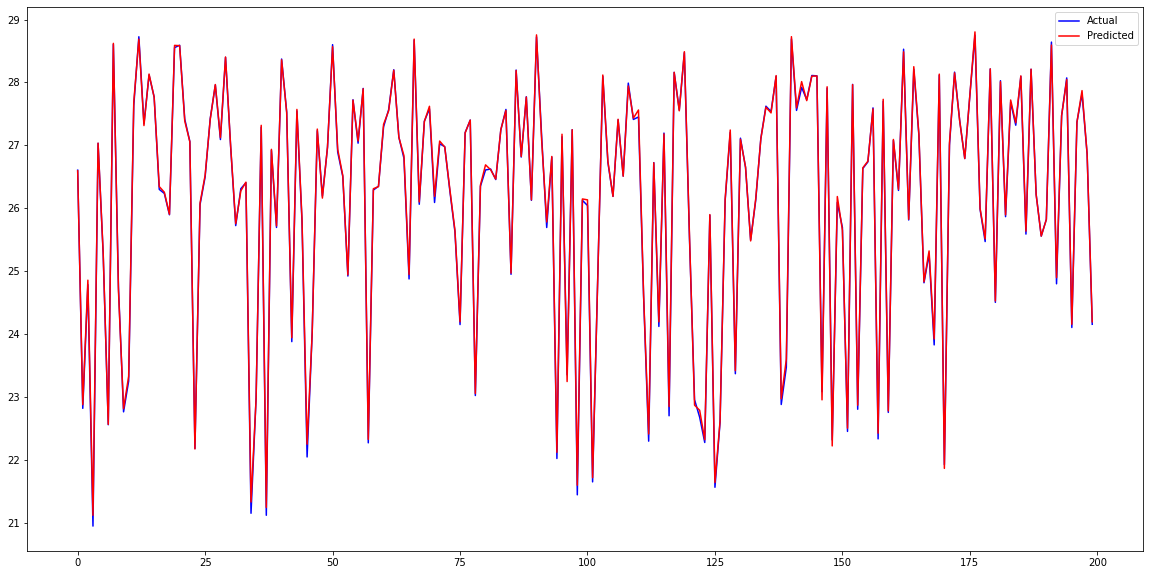

In [ ]:
# Train the model
start = time.time()
model.fit(X_train_pca, y_train_pca, epochs=100, verbose=0)
stop = time.time()
nn_pca_train_time = stop - start
print(f"Training time: {nn_pca_train_time}s")

# Predict on test data
y_pred_nn_pca = model.predict(X_test_pca)
model.save('../reports/models/nn_MRT_pca_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_nn_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Save training times to a csv file
import csv

with open('../reports/data/training_times_enclosed_office_MRT.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Model', 'Training time (s)'])
    writer.writerow(['Linear regression', lr_train_time])
    writer.writerow(['Linear regression with PCA', lr_pca_train_time])
    writer.writerow(['Neural network', nn_train_time])
    writer.writerow(['Neural network with PCA', nn_pca_train_time])

### 4. Compare models' results with and without PCA on predicting T

#### 4.1 Split the data into training and testing

In [ ]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split

# Without PCA
X_train, X_test, y_train, y_test = train_test_split(X_std, y_T, test_size=0.2, random_state=42)

# With PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_T, test_size=0.2, random_state=42)

#### 4.2 Train and evaluate the Linear Regression model

##### 4.2.1 Without PCA

Training time: 0.009361028671264648s
Mean squared error: 0.13248888237360454


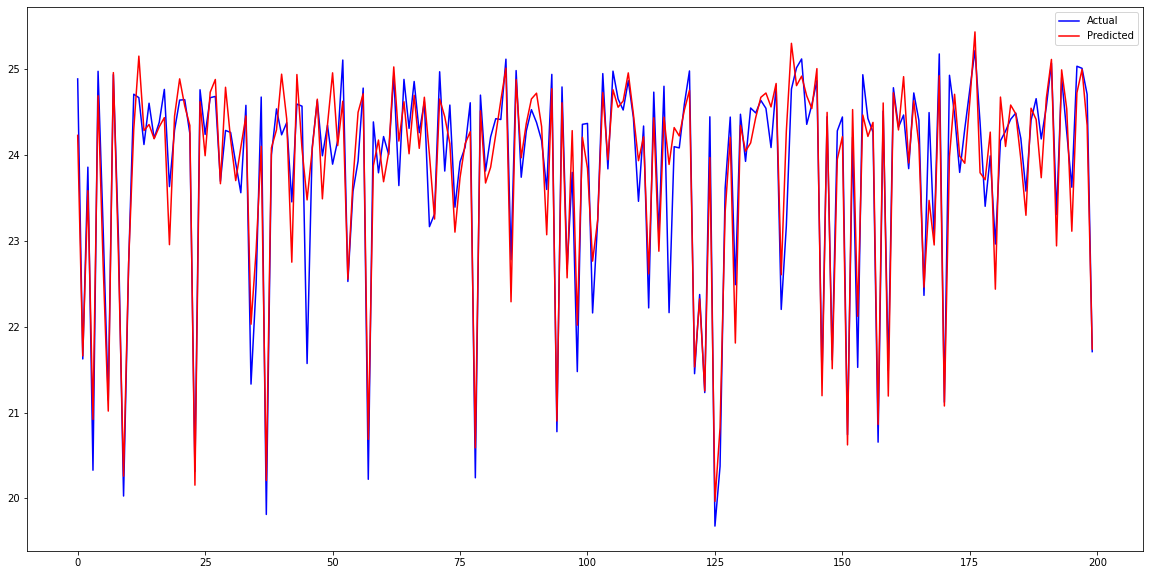

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
import time

# Train linear regression model on training data
model = LinearRegression()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
lr_train_time = stop - start
print(f"Training time: {lr_train_time}s")

# Save the model to a pickle file
filename = '../reports/models/lr_T_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred[:144], color='red', label='Predicted')
plt.legend()
plt.show()

##### 4.2.2 With PCA

Training time: 0.011274337768554688s
Mean squared error: 0.13248888237360457


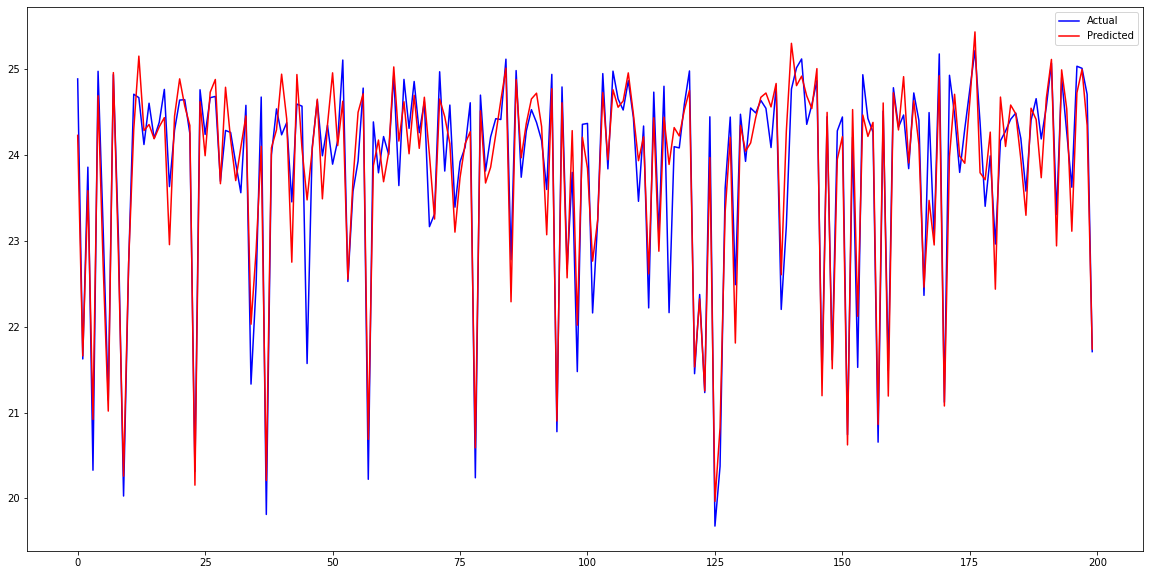

In [ ]:
# Train linear regression model on training data
start = time.time()
model.fit(X_train_pca, y_train_pca)
stop = time.time()
lr_pca_train_time = stop - start
print(f"Training time: {lr_pca_train_time}s")

# Predict on test data
y_pred_pca = model.predict(X_test_pca)

# Save the model to a pickle file
filename = '../reports/models/lr_T_pca_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

#### 4.3 Train and evaluate the Feedforward Neural Network model

##### 4.2.1 Without PCA

Training time: 198.21673274040222s
INFO:tensorflow:Assets written to: ../reports/models/nn_T_conference_room_model.pkl/assets
Mean squared error: 0.028228071596030416


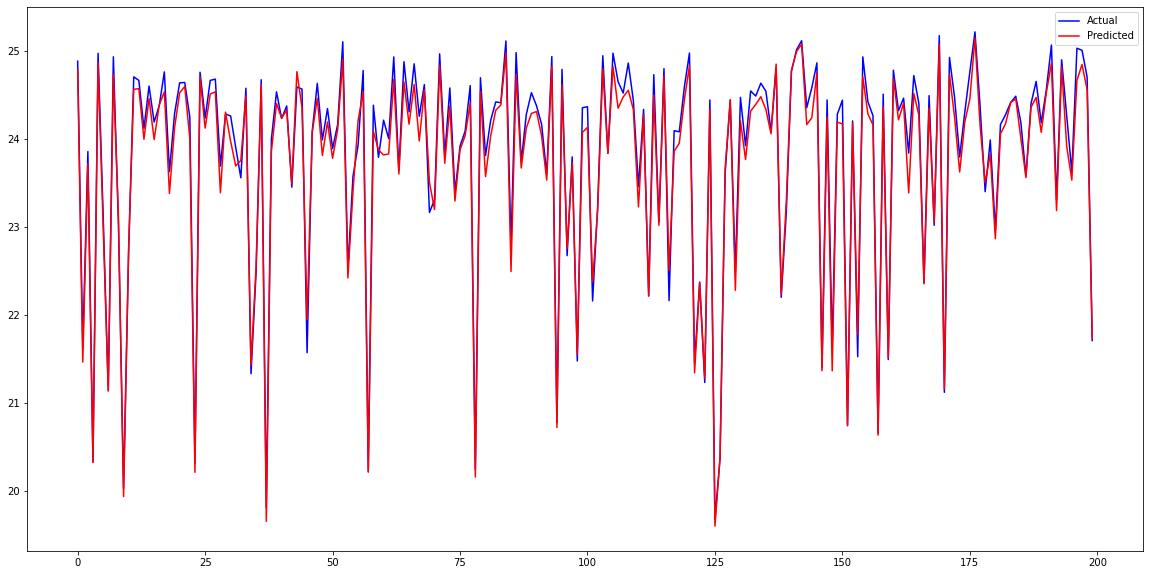

In [ ]:
# Create neural network model 
from keras.models import Sequential
from keras.layers import Dense

N_NEURONS = 1024
N_LAYERS = 4

model = Sequential()
model.add(Dense(units=N_NEURONS, input_dim=X.shape[1], activation='relu'))
for i in range(N_LAYERS-1):
    model.add(Dense(units=N_NEURONS, activation='relu'))
model.add(Dense(units=1, activation='linear')) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
start = time.time()
model.fit(X_train, y_train, epochs=100, verbose=0)
stop = time.time()
nn_train_time = stop - start
print(f"Training time: {nn_train_time}s")

# Predict on test data
y_pred_nn = model.predict(X_test)
model.save('../reports/models/nn_T_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_nn)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn[:144], color='red', label='Predicted')
plt.legend()
plt.show()

##### 4.3.2 With PCA

Training time: 199.61321687698364s
INFO:tensorflow:Assets written to: ../reports/models/nn_T_pca_conference_room_model.pkl/assets
Mean squared error: 0.01676264223699558


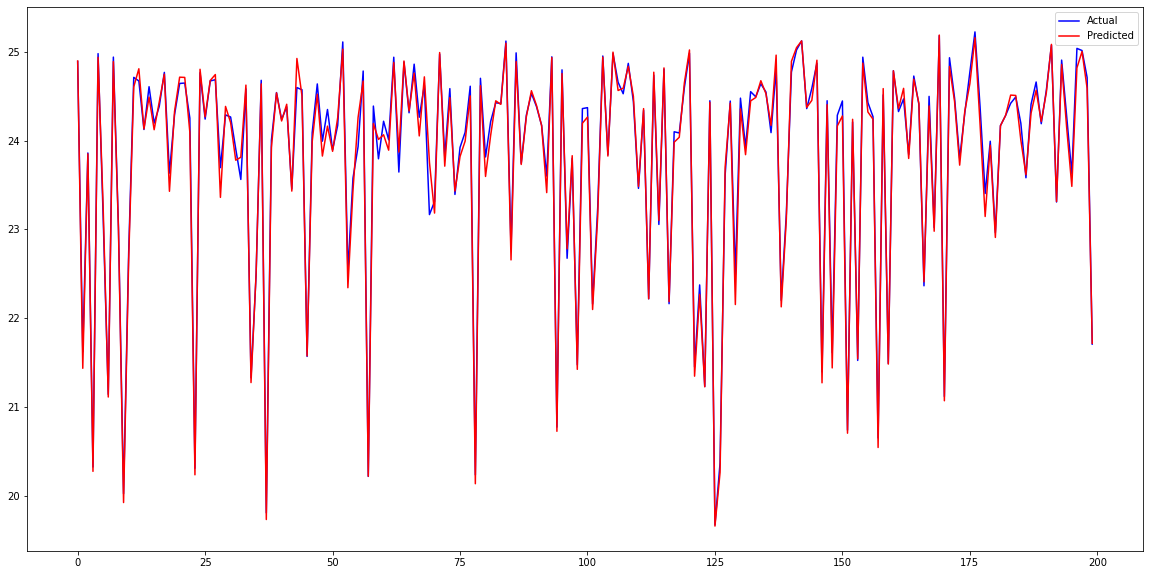

In [ ]:
# Train the model
start = time.time()
model.fit(X_train_pca, y_train_pca, epochs=100, verbose=0)
stop = time.time()
nn_pca_train_time = stop - start
print(f"Training time: {nn_pca_train_time}s")

# Predict on test data
y_pred_nn_pca = model.predict(X_test_pca)
model.save('../reports/models/nn_T_pca_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_nn_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Save training times to a csv file
import csv

with open('../reports/data/training_times_enclosed_office_T.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Model', 'Training time (s)'])
    writer.writerow(['Linear regression', lr_train_time])
    writer.writerow(['Linear regression with PCA', lr_pca_train_time])
    writer.writerow(['Neural network', nn_train_time])
    writer.writerow(['Neural network with PCA', nn_pca_train_time])

### 5. Compare models' results with and without PCA on predicting V

#### 5.1 Split the data into training and testing

In [ ]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split

# Without PCA
X_train, X_test, y_train, y_test = train_test_split(X_std, y_V, test_size=0.2, random_state=42)

# With PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_V, test_size=0.2, random_state=42)

#### 5.2 Train and evaluate the Linear Regression model

##### 5.2.1 Without PCA

Training time: 0.014678001403808594s
Mean squared error: 0.001118630731868217


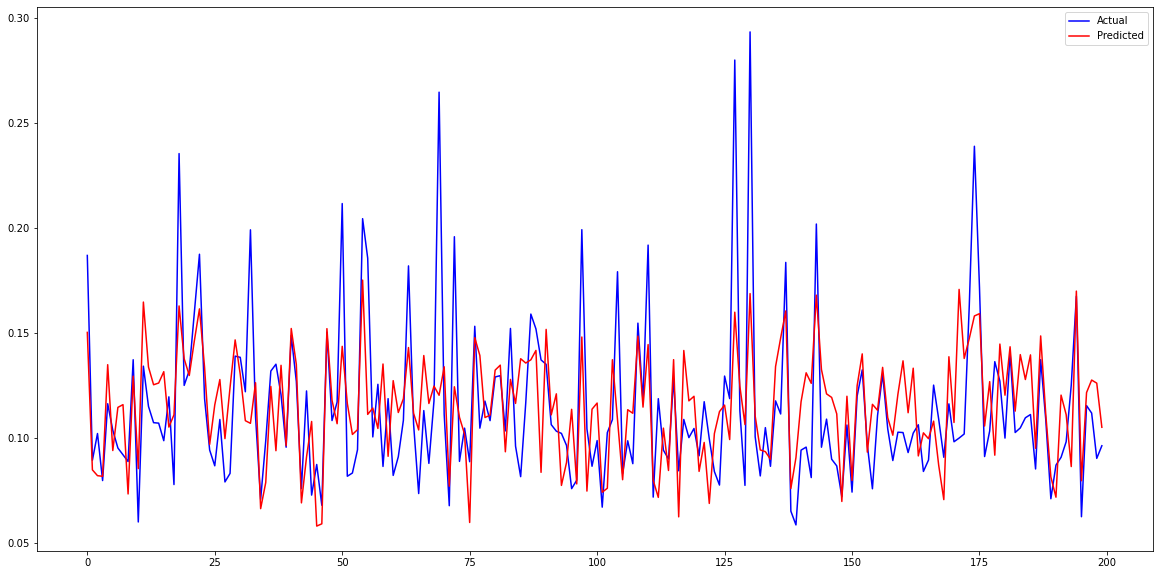

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
import time

# Train linear regression model on training data
model = LinearRegression()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
lr_train_time = stop - start
print(f"Training time: {lr_train_time}s")

# Save the model to a pickle file
filename = '../reports/models/lr_V_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred[:144], color='red', label='Predicted')
plt.legend()
plt.show()

##### 5.2.2 With PCA

Training time: 0.012313365936279297s
Mean squared error: 0.001118630731868217


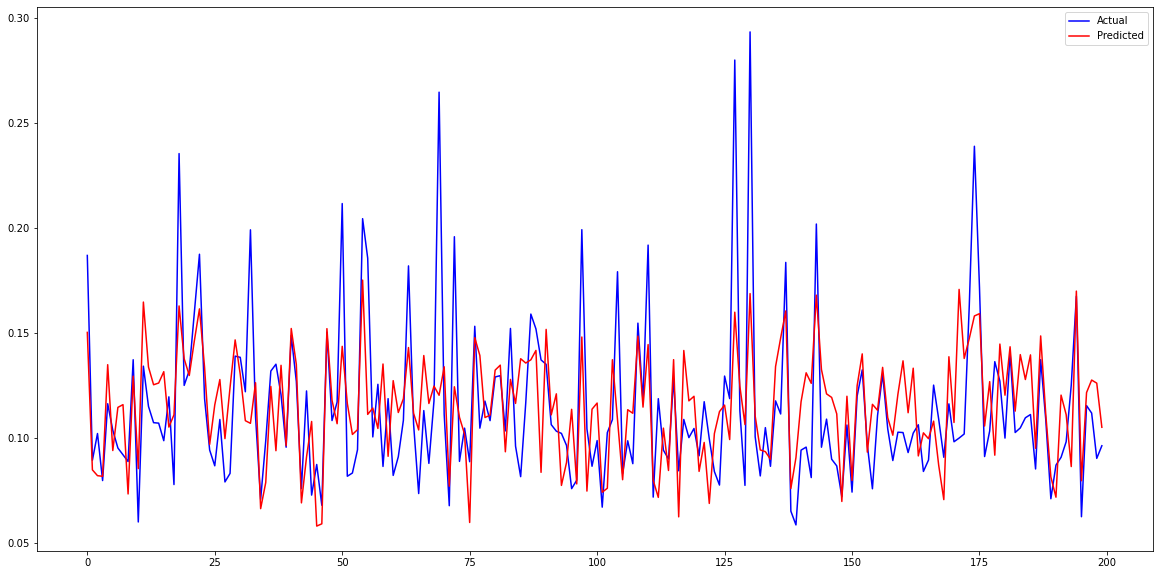

In [ ]:
# Train linear regression model on training data
start = time.time()
model.fit(X_train_pca, y_train_pca)
stop = time.time()
lr_pca_train_time = stop - start
print(f"Training time: {lr_pca_train_time}s")

# Predict on test data
y_pred_pca = model.predict(X_test_pca)

# Save the model to a pickle file
filename = '../reports/models/lr_V_pca_enclosed_office_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

#### 5.3 Train and evaluate the Feedforward Neural Network model

##### 5.2.1 Without PCA

Training time: 203.27048873901367s
INFO:tensorflow:Assets written to: ../reports/models/nn_V_conference_room_model.pkl/assets
Mean squared error: 0.0003013890718162625


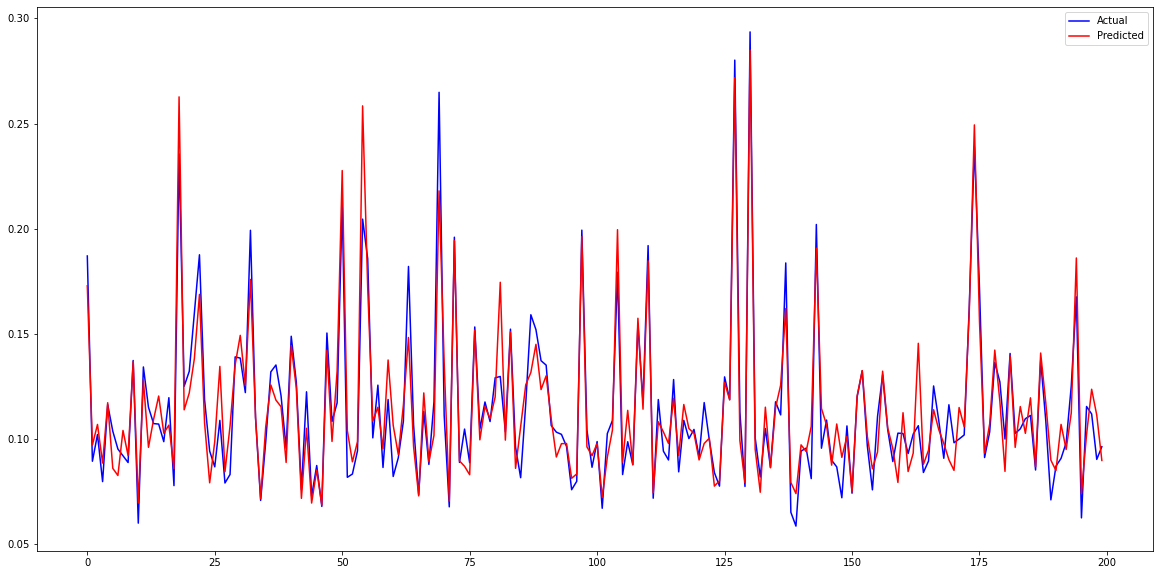

In [ ]:
# Create neural network model 
from keras.models import Sequential
from keras.layers import Dense

N_NEURONS = 1024
N_LAYERS = 4

model = Sequential()
model.add(Dense(units=N_NEURONS, input_dim=X.shape[1], activation='relu'))
for i in range(N_LAYERS-1):
    model.add(Dense(units=N_NEURONS, activation='relu'))
model.add(Dense(units=1, activation='linear')) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
start = time.time()
model.fit(X_train, y_train, epochs=100, verbose=0)
stop = time.time()
nn_train_time = stop - start
print(f"Training time: {nn_train_time}s")

# Predict on test data
y_pred_nn = model.predict(X_test)
model.save('../reports/models/nn_V_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_nn)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn[:144], color='red', label='Predicted')
plt.legend()
plt.show()

##### 5.3.2 With PCA

Training time: 193.58191180229187s
INFO:tensorflow:Assets written to: ../reports/models/nn_V_pca_conference_room_model.pkl/assets
Mean squared error: 0.00030001247540154495


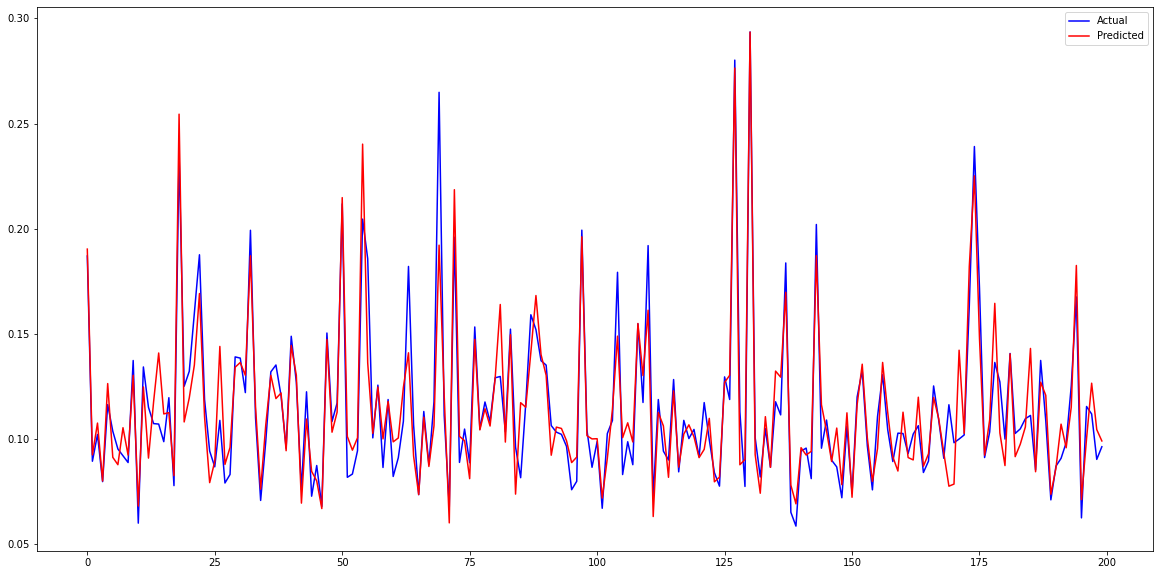

In [ ]:
# Train the model
start = time.time()
model.fit(X_train_pca, y_train_pca, epochs=100, verbose=0)
stop = time.time()
nn_pca_train_time = stop - start
print(f"Training time: {nn_pca_train_time}s")

# Predict on test data
y_pred_nn_pca = model.predict(X_test_pca)
model.save('../reports/models/nn_V_pca_enclosed_office_model.pkl')

# Evaluate the model
mse = mean_squared_error(y_test_pca, y_pred_nn_pca)
print(f'Mean squared error: {mse}')

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(144), y_test_pca[:144], color='blue', label='Actual')
plt.plot(range(144), y_pred_nn_pca[:144], color='red', label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Save training times to a csv file
import csv

with open('../reports/data/training_times_enclosed_office_V.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Model', 'Training time (s)'])
    writer.writerow(['Linear regression', lr_train_time])
    writer.writerow(['Linear regression with PCA', lr_pca_train_time])
    writer.writerow(['Neural network', nn_train_time])
    writer.writerow(['Neural network with PCA', nn_pca_train_time])